In [1]:
import time
import numpy as np
from numpy import random
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import tensorflow as tf
from matplotlib import pyplot as plt
import os

In [2]:
image = np.load('world.npy')
def get_map_sample(size = 56, plot = False):
    
    while(True):
        x = random.randint(67200-size)
        y = random.randint(172800-size)
        subim = image[x:size+x, y:size+y, 0]

        if np.all(subim > 0) & (np.max(subim) > np.min(subim) + 100):
            subim = (subim - np.mean(subim)) / 3000
            subim[8:48,8:48] = 0
            if(plot):
                fig = plt.figure(figsize=(15,6))
                ax = fig.add_subplot(1, 2, 1)
                ax.imshow(subim)
                m,n = subim.shape
                R,C = np.mgrid[:m,:n]
                X = C.ravel() * 30
                Y = R.ravel() * 30
                Z = subim.ravel()
                ax = fig.add_subplot(1, 2, 2, projection='3d')
                ax.plot_trisurf(X, Y, Z, linewidth=0, antialiased=False, cmap = 'gray')
                ax.set_zlim(0, 1)
            

            yield(subim.reshape(size,size, 1))
        else:
            next
            


In [6]:
def build_generator():
    # want this to tank in the masked image and produce a new image of the same size
    # let's assume an image of 56x56 with a 32x32 mask in the center. 
    
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(8, (5,5), strides=(2, 2), use_bias=False, input_shape=[56, 56, 1], padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(16, (5,5), strides=(2, 2), use_bias=False, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(32, (5,5), use_bias=False, input_shape=(64, 64,), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.UpSampling2D(interpolation='bilinear'))
    model.add(layers.Conv2D(32, (5,5), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.UpSampling2D(interpolation='bilinear'))
    model.add(layers.Conv2D(16, (5,5), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.UpSampling2D(interpolation='bilinear'))
    model.add(layers.Conv2D(8, (5,5), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(1, (5,5), padding='same'))

    return model

def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[56, 56, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

class GAN():
    def __init__(self, 
                 dataset, 
                 batch_size, 
                 epochs, 
                 noise_dim, 
                 discriminator, 
                 generator, 
                 discriminator_optimizer = tf.keras.optimizers.Adam(1e-4), 
                 generator_optimizer = tf.keras.optimizers.Adam(1e-4)):
        self.BATCH_SIZE = batch_size
        self.epochs = epochs
        self.noise_dim = noise_dim
        self.seed = tf.random.normal([4, self.noise_dim])
        self.dataset = tf.data.Dataset.from_generator(dataset, tf.float32, tf.TensorShape([56, 56, 1])).batch(self.BATCH_SIZE)
        self.discriminator = discriminator
        self.generator = generator
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_optimizer = generator_optimizer
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)
    
    @tf.function
    def train_step(self, images):
        noise = tf.random.normal([self.BATCH_SIZE, self.noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)
  
            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

    def train(self):
        for epoch in range(self.epochs):
            start = time.time()

            for image_batch in self.dataset.take(1): 
                self.train_step(image_batch)
            


            # Save the model every 15 epochs
            if (epoch + 1) % 15 == 0:
                # Produce images for the GIF as we go
                # display.clear_output(wait=True)
                self.generate_and_save_images(self.generator,
                                         epoch + 1,
                                         self.seed)
                
                checkpoint_dir = './training_checkpoints'
                checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
                checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                                 discriminator_optimizer=self.discriminator_optimizer,
                                                 generator=self.generator,
                                                 discriminator=self.discriminator)
                checkpoint.save(file_prefix = checkpoint_prefix)

            print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generate after the final epoch
#         display.clear_output(wait=True)
        self.generate_and_save_images(self.generator,
                               self.epochs,
                               self.seed)
        
    def generate_and_save_images(self, model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
        predictions = model(test_input, training=False)

        fig = plt.figure(figsize=[8,4])
        ax = fig.add_subplot(1,2,1)
        ax.imshow(predictions[0,:,:,0], cmap ='gray', vmin = -750/3000, vmax = 750/3000)

        ax = fig.add_subplot(1,2,2, projection='3d')
        predictions = predictions.numpy()[0,:,:,0]
        m,n = predictions.shape
        R,C = np.mgrid[:m,:n]
        surf = ax.plot_trisurf(30*C.ravel(),30*R.ravel(), (3000) * predictions.ravel(), cmap='gray',
                               linewidth=0, antialiased=False, vmin = -750, vmax = 750)
        ax.set_zlim(-750, 750)        
        
#         fig = plt.figure(figsize=(4,4))

#         for i in range(predictions.shape[0]):
#             plt.subplot(4, 4, i+1)
#             plt.imshow(predictions[i, :, :, 0], cmap='gray')
#             plt.axis('off')

        plt.savefig('./images/image_at_epoch_{:04d}.png'.format(epoch))
        plt.show()

In [4]:
# generator = build_generator()
# discriminator = build_discriminator()

# gan = GAN(dataset = get_map_sample, batch_size = 1000, epochs = 9000, noise_dim = 100, discriminator=discriminator, generator=generator)


In [5]:
# gan.train()

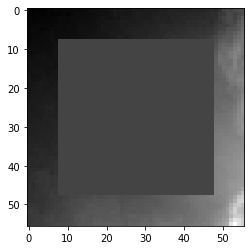

In [6]:
samp = next(get_map_sample())
plt.imshow(samp[:,:,0], cmap ='gray')
# gan.discriminator(samp.reshape(1,56,56,1))

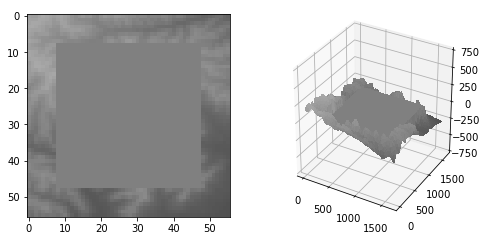

In [3]:
samp = next(get_map_sample())
fig = plt.figure(figsize=[8,4])
ax = fig.add_subplot(1,2,1)
ax.imshow(samp[:,:,0], cmap ='gray', vmin = -750/3000, vmax = 750/3000)

ax = fig.add_subplot(1,2,2, projection='3d')
samp = samp[:,:,0] 
m,n = samp.shape
R,C = np.mgrid[:m,:n]
surf = ax.plot_trisurf(30*C.ravel(),30*R.ravel(), (3000) * samp.ravel(), cmap='gray',
                       linewidth=0, antialiased=False, vmin = -750, vmax = 750)
ax.set_zlim(-750, 750)
plt.show()

In [7]:
# gen = build_generator()
dis = build_discriminator()

In [8]:
dis.compile()
dis(samp.reshape(1,56,56,1))

ValueError: The model cannot be compiled because it has no loss to optimize.

In [ ]:
next(sample).reshape(1,56,56,1)

In [ ]:
gan.discriminator(next(sample).reshape(1,56,56,1))